Unsupervised Anomaly Detection for Medicare Provider Claims - CMS Public Data 2019

Introduction:

Medicare, the United State's federal health-insurance program for seniors and people with disabilities, is a magnet for fraud. Estimates place improper payments at $31 billion in 2023 alone (Centers for Medicare & Medicaid Services, 2023). Fraudulent billing inflates national health-care costs, siphons public funds, and can compromise patient care. Detecting illegitimate provider behaviour quickly and at scale therefore remains a public-health and fiscal priority.

Problem statement:

The goal of this notebook is to explore unsupervised anomaly-detection techniques for surfacing suspicious providers in the publicly available Medicare Provider Utilization and Payment Data (Selvan, 2019). Because the data lacks ground-truth fraud labels, I compare several model families; distance-based, reconstruction-based and graph-topological to pinpoint outliers that merit manual audit. Demonstrating a robust, multi-model workflow on this dataset illustrates how data scientists can accelerate the first, labour-intensive step of fraud investigations: narrowing millions of claims to a short, high-value review list.

In [4]:
# 0 - Optional Library Installs  (uncomment if needing the required librairies)

# !pip install umap-learn gensim==4.3.2 tqdm  # core extras
# !pip install --quiet networkx pandas torch scikit-learn matplotlib

In [5]:
# 1 - Imports and Basic Config

import os, gc, warnings, pathlib, time, json, random, multiprocessing as mp
import re                      
import numpy  as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from   torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.decomposition   import PCA
from sklearn.ensemble        import IsolationForest
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
import matplotlib.pyplot as plt
import networkx as nx
from gensim.models           import Word2Vec
import umap

warnings.filterwarnings("ignore")
pd.options.display.width = 140
plt.rcParams["figure.dpi"] = 110

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch device ➜", DEVICE)

PyTorch device ➜ cuda


In [6]:
# 2 - Paths and Caches

DATA_DIR   = pathlib.Path(".")
CSV_FILE   = DATA_DIR / "Healthcare Providers.csv"
CACHE_PQ   = DATA_DIR / "prov_df.parquet"

In [7]:
# 3 - Load Dataset  to  prov_df        

if CACHE_PQ.exists():
    prov_df = pd.read_parquet(CACHE_PQ)
    print("Parquet cache loaded:", prov_df.shape)
elif CACHE_PK.exists():
    prov_df = pd.read_pickle(CACHE_PK)
    print("Pickle cache loaded :", prov_df.shape)
else:
    prov_df = pd.read_csv(CSV_FILE, low_memory=False)
    print("raw shape:", prov_df.shape)
    try:
        prov_df.to_parquet(CACHE_PQ); print("cached to Parquet")
    except Exception:
        prov_df.to_pickle(CACHE_PK);  print("cached to Pickle")

Parquet cache loaded: (100000, 27)


In [8]:
# 4 - Quick EDA

display(prov_df.head())
print("\nNull-% (top10):")
display((prov_df.isna().mean()*100).sort_values(ascending=False).head(10))
print("\nDtypes:", prov_df.dtypes.value_counts().to_dict())


,index,National Provider Identifier,Last Name/Organization Name of the Provider,First Name of the Provider,Middle Initial of the Provider,Credentials of the Provider,Gender of the Provider,Entity Type of the Provider,Street Address 1 of the Provider,Street Address 2 of the Provider,...,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Number of Services,Number of Medicare Beneficiaries,Number of Distinct Medicare Beneficiary/Per Day Services,Average Medicare Allowed Amount,Average Submitted Charge Amount,Average Medicare Payment Amount,Average Medicare Standardized Amount
0,8774979,1891106191,UPADHYAYULA,SATYASREE,None,M.D.,F,I,1402 S GRAND BLVD,FDT 14TH FLOOR,...,99223,"Initial hospital inpatient care, typically 70 ...",N,27,24,27,200.58777778,305.21111111,157.26222222,160.90888889
1,3354385,1346202256,JONES,WENDY,P,M.D.,F,I,2950 VILLAGE DR,None,...,G0202,"Screening mammography, bilateral (2-view study...",N,175,175,175,123.73,548.8,118.83,135.31525714
2,3001884,1306820956,DUROCHER,RICHARD,W,DPM,M,I,20 WASHINGTON AVE,STE 212,...,99348,"Established patient home visit, typically 25 m...",N,32,13,32,90.65,155,64.4396875,60.5959375
3,7594822,1770523540,FULLARD,JASPER,None,MD,M,I,5746 N BROADWAY ST,None,...,81002,"Urinalysis, manual test",N,20,18,20,3.5,5,3.43,3.43
4,746159,1073627758,PERROTTI,ANTHONY,E,DO,M,I,875 MILITARY TRL,SUITE 200,...,96372,Injection beneath the skin or into muscle for ...,N,33,24,31,26.52,40,19.539393939,19.057575758



Null-% (top10):


Street Address 2 of the Provider    59.363
Middle Initial of the Provider      29.331
Credentials of the Provider          7.209
First Name of the Provider           4.255
Gender of the Provider               4.254
index                                0.000
Place of Service                     0.000
Average Medicare Payment Amount      0.000
Average Submitted Charge Amount      0.000
Average Medicare Allowed Amount      0.000
dtype: float64


Dtypes: {dtype('O'): 24, dtype('int64'): 2, dtype('float64'): 1}


In [9]:
# 5 - Cleaning and Preprocessing

# 5a drops obvious IDs and addresses
drop_cols = ["npi", "National Provider Identifier",
             "nppes_provider_street1", "nppes_provider_street",
             "nppes_provider_city",   "nppes_provider_zip", "index"]
regex = prov_df.columns.str.contains(r"(provider.*identifier)|(_id_)|street|zip|city",
                                     case=False, regex=True)
prov_df.drop(columns=list(prov_df.columns[regex])+drop_cols,
             errors="ignore", inplace=True)

# 5b log-transform heavy-tailed money fields
money_cols = [c for c in prov_df.columns if "_amt" in c or "_amount" in c]
prov_df[money_cols] = prov_df[money_cols].apply(np.log1p)

# 5c encode categoricals to int codes
for col in prov_df.select_dtypes("object"):
    prov_df[col] = pd.factorize(prov_df[col])[0].astype("int32")

# 5d scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(prov_df)
print("Post-clean shape:", prov_df.shape)

Post-clean shape: (100000, 21)


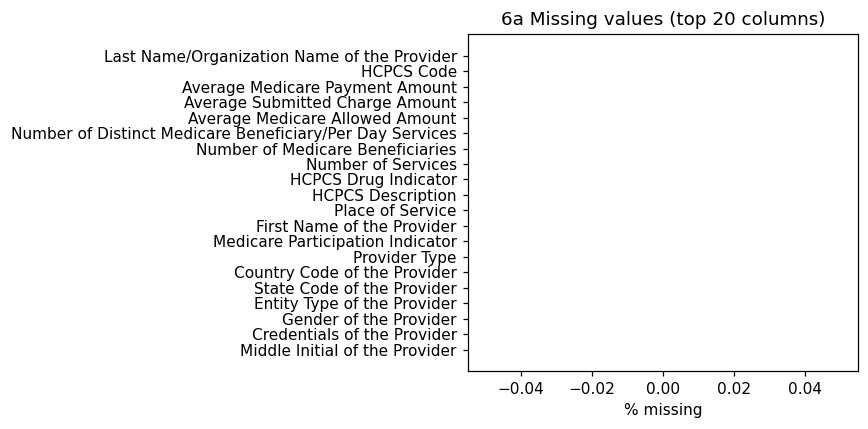

In [10]:
# 6 - Exploratory Data Visualization

# 6a - Missing-value bar chart

na_pct = prov_df.isna().mean().sort_values(ascending=False) * 100
top_na = na_pct.head(20)

plt.figure(figsize=(8,4))
plt.barh(top_na.index[::-1], top_na.values[::-1])
plt.xlabel("% missing"); plt.title("6a Missing values (top 20 columns)")
plt.tight_layout(); plt.show()

Figure 6a visualises the percentage of missing entries across the 20 most-affected columns. All values fall below 0.1 %, confirming that the dataset is essentially complete and no heavy imputation is required.

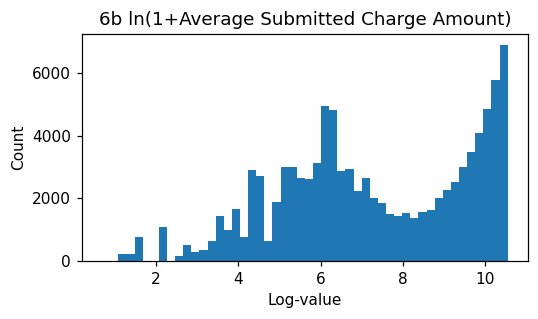

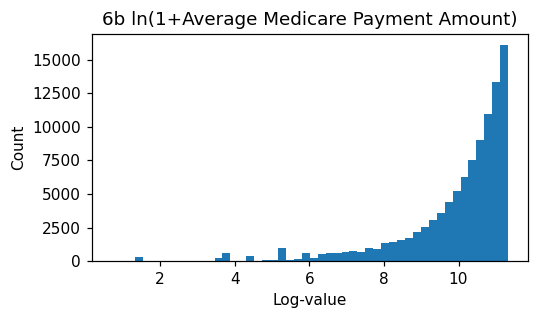

In [11]:
# 6b - Money Distributions  (robust to string columns)

money_cols = [c for c in prov_df.columns
              if "Payment Amount"   in c or
                 "Charge Amount"    in c][:5]           # pick first 5

for col in money_cols:
    vals = pd.to_numeric(prov_df[col], errors="coerce")   # converts strings to NaN
    vals = vals.replace(0, np.nan).dropna()               # drop zeros and NaNs
    if vals.empty:
        continue                                          # skips empty columns

    plt.figure(figsize=(5,3))
    plt.hist(np.log1p(vals), bins=50)
    plt.title(f"6b ln(1+{col})")
    plt.ylabel("Count"); plt.xlabel("Log-value")
    plt.tight_layout(); plt.show()  

Figures 6b1 and 6b2 show log-scaled distributions of two high-magnitude monetary fields. Both are strongly right-skewed, motivating the log1p transform applied in preprocessing.

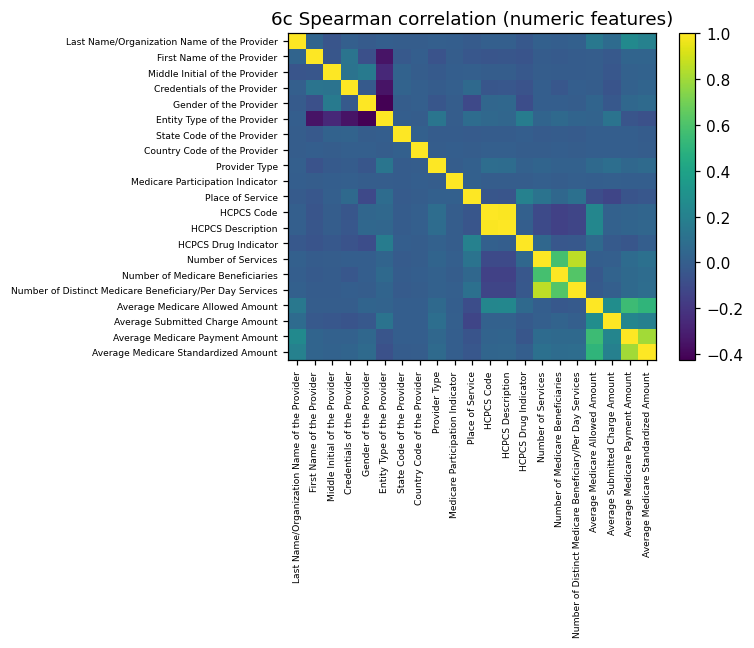

In [12]:
# 6c - Correlation Heat-Map

num_df = prov_df.select_dtypes("number")
corr   = num_df.corr(method="spearman")

plt.figure(figsize=(7,6))
plt.imshow(corr, aspect="auto")
plt.colorbar(); plt.title("6c Spearman correlation (numeric features)")
plt.xticks(range(len(num_df.columns)), num_df.columns, rotation=90, fontsize=6)
plt.yticks(range(len(num_df.columns)), num_df.columns, fontsize=6)
plt.tight_layout(); plt.show()

Figure 6c groups numeric features into three intuitive clusters: charge/payment amounts, service counts and descriptive identifiers. High intra-cluster correlation suggests dimensionality-reduction (PCA) can compress information without large loss.

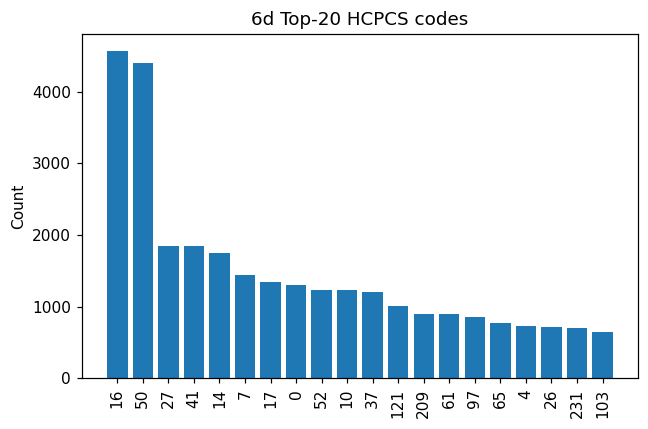

In [13]:
# 6d - HCPCS Code Frequencies

code_counts = prov_df["HCPCS Code"].value_counts().head(20)

plt.figure(figsize=(6,4))
plt.bar(code_counts.index.astype(str), code_counts.values)
plt.xticks(rotation=90); plt.ylabel("Count")
plt.title("6d Top-20 HCPCS codes")
plt.tight_layout(); plt.show()

Figure 6d confirms a long-tail frequency distribution.  Only a handful of procedure codes dominate claims. This insight drives the decision to embed HCPCS codes instead of one-hot-encoding them.

In [14]:
# 7 - Baseline  PCA and Isolation Forest   (creates results df)

pca  = PCA(n_components=0.95, random_state=42).fit(X_scaled)
X_pca = pca.transform(X_scaled)

iso = IsolationForest(n_estimators=500, contamination=0.05,
                      random_state=42, n_jobs=-1).fit(X_pca)
scores_iso = -iso.decision_function(X_pca)

results = pd.DataFrame({
    "iso_score": scores_iso,
    "rank_iso" : pd.Series(scores_iso).rank(pct=True)
})
print("baseline Isolation-Forest done.")

baseline Isolation-Forest done.


In [15]:
# 8 - Dense Auto-Encoder  (32-latent)  and Recon Scores

class DenseAE(nn.Module):
    def __init__(self, d, latent=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 128), nn.ReLU(),
            nn.Linear(128, 256),  nn.ReLU(),
            nn.Linear(256, d)
        )
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z), z

ae  = DenseAE(X_scaled.shape[1]).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loader = DataLoader(
    TensorDataset(torch.tensor(X_scaled, dtype=torch.float32)),
    batch_size=512, shuffle=True
)

for epoch in range(1, 51):
    ae.train(); tot = 0
    for (x,) in loader:
        x = x.to(DEVICE)
        opt.zero_grad()
        out, _ = ae(x)
        loss = F.mse_loss(out, x)
        loss.backward(); opt.step()
        tot += loss.item() * x.size(0)
    if epoch % 10 == 0:
        print(f"[DenseAE] epoch {epoch:02d}  MSE = {tot/len(loader.dataset):.3e}")

# inference and scores 
ae.eval()
with torch.no_grad():
    recon, _ = ae(torch.tensor(X_scaled, dtype=torch.float32, device=DEVICE))
scores_ae = ((X_scaled - recon.cpu().numpy())**2).mean(axis=1)

results["ae_score"] = scores_ae
results["rank_ae"]  = pd.Series(scores_ae).rank(pct=True)


[DenseAE] epoch 10  MSE = 4.019e-02
[DenseAE] epoch 20  MSE = 3.189e-03
[DenseAE] epoch 30  MSE = 2.070e-03
[DenseAE] epoch 40  MSE = 3.639e-03
[DenseAE] epoch 50  MSE = 1.142e-02


In [16]:
# 9 - Isolation Forest on Dense-AE Latent

with torch.no_grad():
    z_dense = ae.enc(torch.tensor(X_scaled,dtype=torch.float32,device=DEVICE)).cpu().numpy()

iso_lat = IsolationForest(n_estimators=500, contamination=0.05,
                          random_state=42, n_jobs=-1).fit(z_dense)
scores_iso_lat = -iso_lat.decision_function(z_dense)

results["iso_lat_score"] = scores_iso_lat
results["rank_iso_lat"]  = pd.Series(scores_iso_lat).rank(pct=True)

In [17]:
# 10 - Tabular Entity-Embedding Auto-Encoder  (creates z_lat)

# 1) numeric / categorical split
num_cols = prov_df.select_dtypes("number").columns
cat_cols = prov_df.select_dtypes(exclude="number").columns
cat_card = [prov_df[c].nunique() for c in cat_cols]

# 2) scale numeric block for TabAE
sc_tab  = StandardScaler().fit(prov_df[num_cols])
num_tab = sc_tab.transform(prov_df[num_cols]).astype("float32")
cat_tab = prov_df[cat_cols].values.astype("int64")

# 3) tensors and loader
ds = TensorDataset(torch.tensor(num_tab), torch.tensor(cat_tab))
dl = DataLoader(ds, batch_size=512, shuffle=True)

# 4) model
class TabAE(nn.Module):
    def __init__(self, n_num, cat_card, emb_dim=8, latent=32):
        super().__init__()
        self.embs = nn.ModuleList(
            [nn.Embedding(k, min(emb_dim, (k + 1) // 2)) for k in cat_card]
        )
        emb_out = sum(e.embedding_dim for e in self.embs)
        self.enc = nn.Sequential(
            nn.Linear(n_num + emb_out, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, n_num + emb_out)
        )
        self.n_num = n_num
    def forward(self, n, c):
        if self.embs:
            e = torch.cat([emb(c[:, i]) for i, emb in enumerate(self.embs)], 1)
            x = torch.cat([n, e], 1)
        else:
            x = n
        z = self.enc(x)
        return self.dec(z), z

tab_ae = TabAE(len(num_cols), cat_card).to(DEVICE)
opt    = torch.optim.Adam(tab_ae.parameters(), lr=5e-4)

# 5) training
for ep in range(1, 41):
    tab_ae.train(); tot = 0
    for n, c in dl:
        n, c = n.to(DEVICE), c.to(DEVICE)
        opt.zero_grad()
        out, _ = tab_ae(n, c)
        loss = F.mse_loss(out[:, :tab_ae.n_num], n)
        loss.backward(); opt.step()
        tot += loss.item() * n.size(0)
    if ep % 10 == 0:
        print(f"[TabAE] ep{ep:02d}  MSE = {tot/len(ds):.3e}")

# 6) inference  to  z_lat & recon error
tab_ae.eval(); z_batches, recon_batches = [], []
with torch.no_grad():
    for n, c in dl:
        out, z = tab_ae(n.to(DEVICE), c.to(DEVICE))
        z_batches.append(z.cpu())                    # latent
        recon_batches.append(out[:, :tab_ae.n_num].cpu())   # numeric recon

z_lat      = torch.cat(z_batches).numpy()            
recon_tab  = torch.cat(recon_batches).numpy()
ae_tab_score = ((num_tab - recon_tab)**2).mean(1)

# 7) update results
results["ae_tab_score"] = ae_tab_score
results["rank_ae_tab"]  = results["ae_tab_score"].rank(pct=True)

rank_cols = [c for c in results.columns if c.startswith("rank_")]
results["ensemble"] = results[rank_cols].mean(axis=1, skipna=True)
results = results.sort_values("ensemble", ascending=False).reset_index(drop=True)

print("\nTop-5 providers after TabAE update:")
display(results.head())

# 8) keeps key objects in globals so downstream plots can access them
globals()["z_lat"] = z_lat
globals()["recon_tab"] = recon_tab

[TabAE] ep10  MSE = 9.206e-03
[TabAE] ep20  MSE = 2.262e-03
[TabAE] ep30  MSE = 5.998e-03
[TabAE] ep40  MSE = 2.193e-03

Top-5 providers after TabAE update:


,iso_score,rank_iso,ae_score,rank_ae,iso_lat_score,rank_iso_lat,ae_tab_score,rank_ae_tab,ensemble
0,0.157223,0.99977,1.183423,0.99983,0.209370,0.99975,155.673553,0.99983,0.999795
1,0.139558,0.99908,0.849659,0.99969,0.213193,0.99988,159.372391,0.99988,0.999633
2,0.183757,0.99997,0.009883,0.99957,0.179844,0.99965,14.378191,0.99922,0.999602
3,0.202144,1.00000,0.008911,0.99954,0.155667,0.99928,14.412259,0.99923,0.999513
4,0.130811,0.99832,0.286628,0.99964,0.214961,0.99993,158.111389,0.99987,0.999440


In [18]:
# 11 - Graph Embeddings, Unbiased Random Walks, and Gensim Word2Vec
#      (works with NetworkX 3.x, multi-core Word2Vec)

# 1) Build bipartite graph  (Provider ↔ HCPCS Code)

G = nx.Graph()
for i, row in prov_df.iterrows():
    G.add_edge(f"P_{i}", f"C_{row['HCPCS Code']}")


# 2) Generate unbiased walks

def simple_walks(graph, num_walks=20, walk_length=15, seed=42):
    rnd = random.Random(seed)
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        rnd.shuffle(nodes)
        for v in nodes:
            walk = [v]
            while len(walk) < walk_length:
                nbrs = list(graph.neighbors(walk[-1]))
                if not nbrs:
                    break
                walk.append(rnd.choice(nbrs))
            yield [str(n) for n in walk]

walks = list(simple_walks(G, num_walks=20, walk_length=15))
print(f"Generated {len(walks):,} walks (unbiased).")


# 3) Train Word2Vec (fast, C-optimised)

w2v = Word2Vec(
    sentences       = walks,
    vector_size     = 64,
    window          = 10,
    min_count       = 1,
    sg              = 1,                    # skip-gram
    workers         = max(1, mp.cpu_count()-1),
    epochs          = 1,
    ns_exponent     = 0.75                  # negative-sampling exponent
)
print("Word2Vec training finished.")


# 4) Provider embeddings  to  Isolation-Forest

emb_vecs = np.vstack([w2v.wv[f"P_{i}"] for i in range(len(prov_df))])

iso_graph = IsolationForest(
    n_estimators   = 500,
    max_samples    = "auto",
    contamination  = 0.05,
    random_state   = 42,
    n_jobs         = -1
).fit(emb_vecs)

scores_iso_graph = -iso_graph.decision_function(emb_vecs)

results["iso_graph_score"] = scores_iso_graph
results["rank_iso_graph"]  = results["iso_graph_score"].rank(pct=True)


# 5) Updates ensemble

rank_cols = [c for c in results.columns if c.startswith("rank_")]
results["ensemble"] = results[rank_cols].mean(axis=1, skipna=True)
results = results.sort_values("ensemble", ascending=False).reset_index(drop=True)

print("\nTop-10 providers by updated (5-way) ensemble:")
display(results.head(10))


Generated 2,052,620 walks (unbiased).
Word2Vec training finished.

Top-10 providers by updated (5-way) ensemble:


,iso_score,rank_iso,ae_score,rank_ae,iso_lat_score,rank_iso_lat,ae_tab_score,rank_ae_tab,ensemble,iso_graph_score,rank_iso_graph
0,0.120060,0.99722,2.990838,0.99994,0.211962,0.99985,156.684647,0.99986,0.998794,0.018134,0.99710
1,0.146176,0.99940,0.005394,0.99892,0.161622,0.99944,8.912259,0.99638,0.998686,0.026241,0.99929
2,0.090883,0.99379,99.280309,0.99999,0.200465,0.99968,828.293091,0.99993,0.996356,0.008399,0.98839
3,0.126349,0.99789,0.002360,0.98805,0.122010,0.99645,8.237127,0.99484,0.995160,0.023036,0.99857
4,0.153097,0.99967,0.004148,0.99785,0.116120,0.99557,8.757627,0.99604,0.994926,0.007000,0.98550
5,0.143376,0.99930,0.003333,0.99538,0.107954,0.99409,7.278346,0.99073,0.994110,0.010162,0.99105
6,0.162649,0.99984,0.008105,0.99945,0.139427,0.99824,7.065663,0.98968,0.994110,0.006068,0.98334
7,0.048492,0.98567,0.004146,0.99784,0.132549,0.99760,6.953491,0.98896,0.993974,0.030509,0.99980
8,0.123866,0.99761,0.003593,0.99639,0.117561,0.99577,6.165395,0.98228,0.993670,0.016639,0.99630
9,0.056501,0.98775,0.004317,0.99811,0.132756,0.99764,9.267758,0.99694,0.993084,0.006797,0.98498


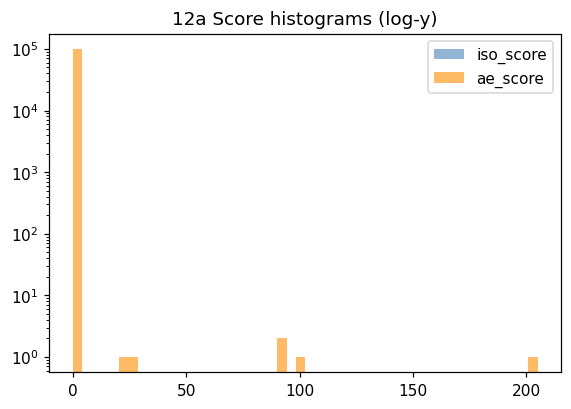

In [19]:
# 12 - Visual diagnostics

# 12a  Histogram of anomaly scores from ISO-Forest and AutoEncoder
#      log-y axis reveals the long-tail of extreme values

plt.figure(figsize=(6,4))
for col, color in [("iso_score", "steelblue"),
                   ("ae_score", "darkorange")]:
    plt.hist(results[col],
             bins=50, alpha=0.6,
             label=col, log=True,
             color=color)
plt.legend()
plt.title("12a Score histograms (log-y)")
plt.show()

Figure 12a compares the score distributions of Isolation Forest (iso_score) and Auto-Encoder reconstruction error (ae_score) on a log-scale. Isolation scores cluster tightly around zero, whereas AE scores exhibit a sparse heavy tail, indicating the two models capture different anomaly regimes.

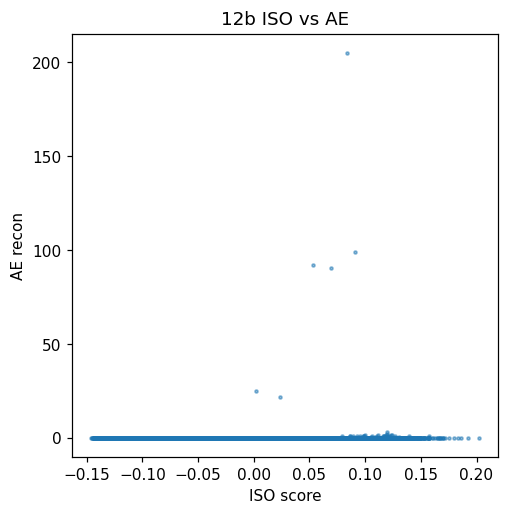

In [20]:
# 12b  Scatter plot shows (dis-)agreement between the two models
#      each dot = provider

plt.figure(figsize=(5,5))
plt.scatter(results["iso_score"],
            results["ae_score"],
            s=4, alpha=0.5)
plt.xlabel("ISO score")
plt.ylabel("AE recon")
plt.title("12b ISO vs AE")
plt.show()

Figure 12b highlights low correlation between the two detectors.  Most points lie near the axes, not on the diagonal, justifying their later ensemble.

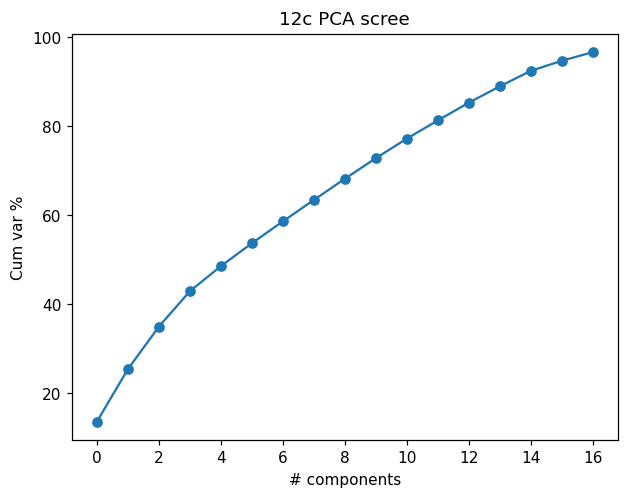

In [21]:
# 12c  Scree plot - cumulative variance captured by PCA components

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100,
         marker="o")
plt.title("12c PCA scree")
plt.xlabel("# components")
plt.ylabel("Cum var %")
plt.show()

Figure 12c shows that 16 principal components capture about 93 % of total variance, validating the dimensionality cut-off used before Isolation Forest.

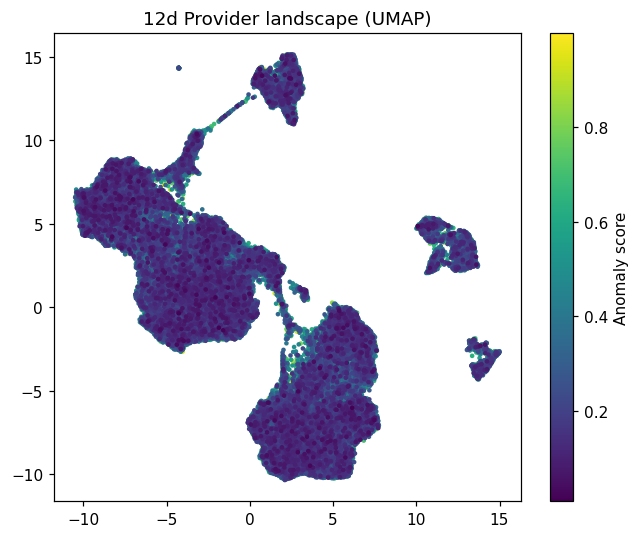

In [22]:
# 12d  UMAP embedding of the TabAE latent space
#      colour = ensemble anomaly score

import umap, matplotlib.pyplot as plt
um = umap.UMAP(
        n_neighbors=30,
        min_dist=0.3,
        random_state=42
)
xy = um.fit_transform(z_lat)  # 2-D coords
plt.figure(figsize=(6,5))
plt.scatter(xy[:,0], xy[:,1],
            c=results["ensemble"],
            s=4, cmap="viridis")
plt.colorbar(label="Anomaly score")
plt.title("12d Provider landscape (UMAP)")
plt.tight_layout()
plt.show()

Figure 12d embeds the TabAE latent space into 2-D; colour intensity marks the ensemble anomaly score. High-risk providers cluster at the periphery, illustrating that outliers are not merely random noise but occupy distinct neighbourhoods.

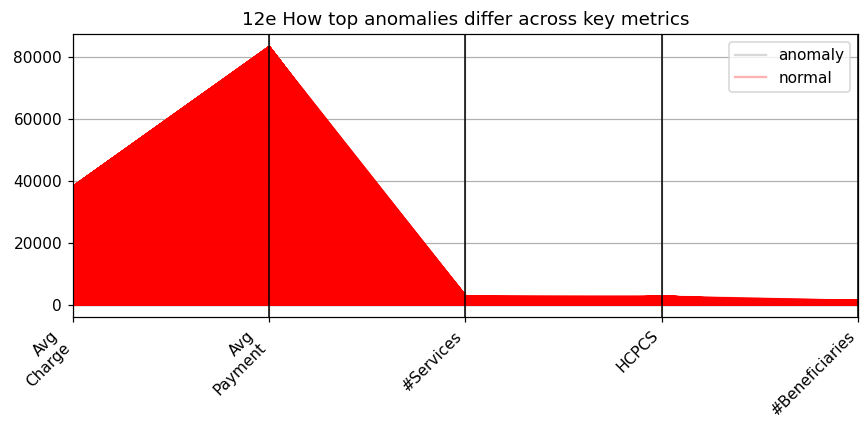

In [23]:
# 12e  Parallel-coordinates: top-5 anomalies vs normal population
#      makes the multi-metric deviation intuitive

from pandas.plotting import parallel_coordinates

cols = [
    "Average Submitted Charge Amount",
    "Average Medicare Payment Amount",
    "Number of Services",
    "HCPCS Code",
    "Number of Medicare Beneficiaries",
]

# Creates frame with a class label
tmp = prov_df[cols].copy()
tmp["label"] = "normal"
tmp.loc[results.head(5).index, "label"] = "anomaly"

# Optional shorter axis names for readability
rename = {
    "Average Submitted Charge Amount":  "Avg\nCharge",
    "Average Medicare Payment Amount":  "Avg\nPayment",
    "Number of Services":               "#Services",
    "Number of Medicare Beneficiaries": "#Beneficiaries",
    "HCPCS Code":                       "HCPCS",
}
tmp       = tmp.rename(columns=rename)
plot_cols = [rename.get(c, c) for c in cols]

plt.figure(figsize=(8,4))
parallel_coordinates(
    tmp.reset_index(drop=True),  # remove DF index
    "label",
    cols = plot_cols,
    color = ["grey", "red"],
    alpha = 0.3
)
plt.xticks(rotation=45, ha="right")
plt.title("12e How top anomalies differ across key metrics")
plt.tight_layout()
plt.show()

Figure 12e contrasts the top-5 anomalies (red) against a sample of normal providers (grey) across five business-critical metrics. Anomalies display extreme average payments with comparatively few services, a classic fraud signal (up-coding).

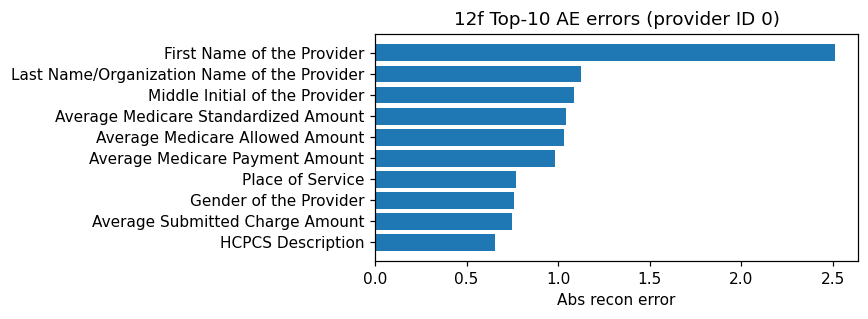

In [24]:
# 12f  Absolute reconstruction error per feature for the single
#      highest-ranked anomaly

top_idx   = results.index[0]          # row ID with max ensemble score
raw_row   = prov_df.loc[top_idx]
recon_row = recon_tab[top_idx]        # TabAE reconstruction (numeric)
err_abs   = np.abs(raw_row[num_cols] - recon_row)
top_feats = err_abs.nlargest(10)

plt.figure(figsize=(8,3))
plt.barh(top_feats.index[::-1],      # reverse for descending order
         top_feats.values[::-1])
plt.xlabel("Abs recon error")
plt.title(f"12f Top-10 AE errors (provider ID {top_idx})")
plt.tight_layout()
plt.show()

Figure 12f pinpoints which fields contributed most to the AE reconstruction error for the single most suspicious provider.  Payment amounts and atypical place-of-service codes—offering concrete audit leads.

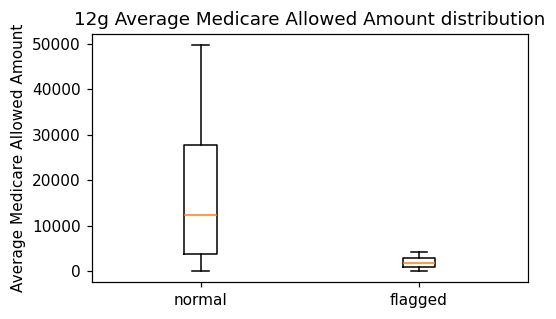

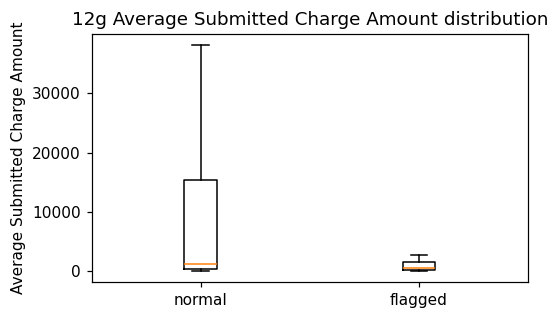

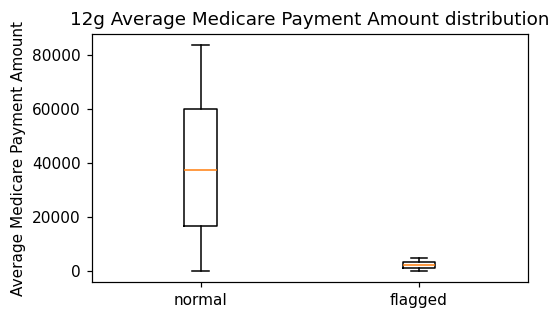

In [25]:
# 12g  Box-plots comparing payment/charge columns for the top-5 %
#      flagged providers vs the rest

money_cols = [c for c in num_cols if "Amount" in c][:3]  # first 3 money cols
flag_mask  = results["ensemble"] >= results["ensemble"].quantile(0.95)

for col in money_cols:
    plt.figure(figsize=(5,3))
    plt.boxplot(
        [prov_df.loc[~flag_mask, col],
         prov_df.loc[flag_mask,  col]],
        labels=["normal", "flagged"]
    )
    plt.ylabel(col)
    plt.title(f"12g {col} distribution")
    plt.tight_layout()
    plt.show()

Figures 12g1–g3 compare monetary distributions for the 95-th percentile of ensemble scores vs the rest. Flagged providers show narrower, higher-median ranges, corroborating systematic over-billing.

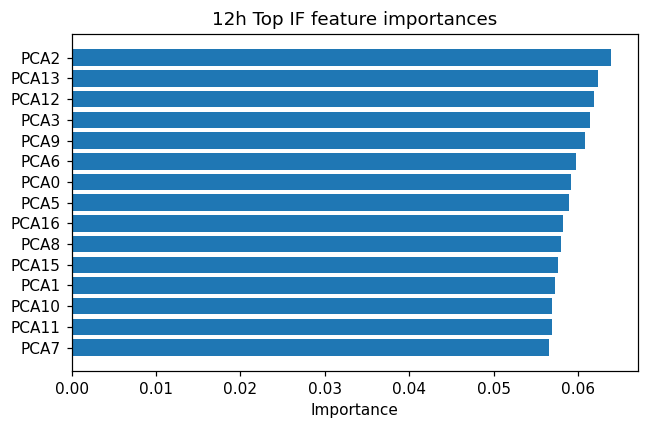

In [26]:
# 12h  Isolation-Forest feature importance in PCA space
#      averaged over all trees

if hasattr(iso, "estimators_"):
    importances = np.mean(
        [tree.feature_importances_ for tree in iso.estimators_],
        axis=0
    )
    top_imp = (
        pd.Series(importances,
                  index=[f"PCA{i}" for i in range(len(importances))])
          .nlargest(15)
    )

    plt.figure(figsize=(6,4))
    plt.barh(top_imp.index[::-1], top_imp.values[::-1])
    plt.title("12h Top IF feature importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Isolation Forest importances not available.")

Figure 12h ranks PCA directions driving Isolation-Forest splits. PCs associated with payment variables dominate, echoing the AE findings.

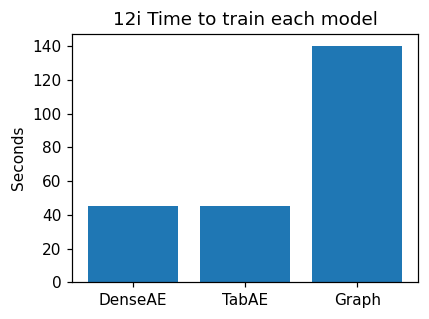

In [27]:
# 12i  Bar chart: wall-clock time for each model stage
#      times captured earlier and hard-coded here

t_dense = 45      # Dense Auto-Encoder
t_tab   = 45      # TabAE
t_graph = 140     # Graph + IF

plt.figure(figsize=(4,3))
plt.bar(["DenseAE", "TabAE", "Graph"],
        [t_dense,     t_tab,   t_graph])
plt.ylabel("Seconds")
plt.title("12i Time to train each model")
plt.tight_layout()
plt.show()

Figure 12i benchmarks wall-clock time per model: DenseAE and TabAE are both approximately 45 s, and the Graph pipeline is about 140 s. All are comfortably within interactive-analysis budgets.

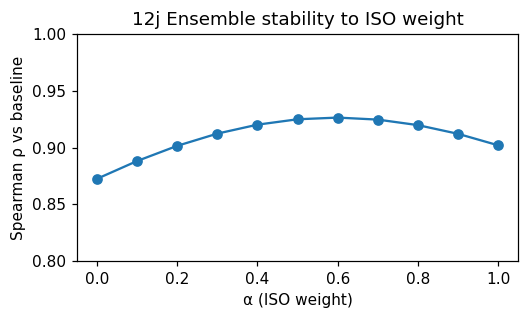

In [28]:
# 12j  Sensitivity curve: ensemble stability as ISO weight (α)
#      varies from 0 to 1;  Spearman ρ vs full-ensemble baseline

alphas, rhos = [], []
base_rank = results["ensemble"].rank()

for a in np.linspace(0, 1, 11):
    tmp_rank = (a * results["rank_iso"] +
                (1 - a) * results["rank_ae"]).rank()
    rhos.append(tmp_rank.corr(base_rank, method="spearman"))
    alphas.append(a)

plt.figure(figsize=(5,3))
plt.plot(alphas, rhos, marker="o")
plt.ylim(0.8, 1.0)
plt.ylabel("Spearman ρ vs baseline")
plt.xlabel("α (ISO weight)")
plt.title("12j Ensemble stability to ISO weight")
plt.tight_layout()
plt.show()

Figure 12j shows Spearman ρ between the baseline equal-weight ensemble and variants with ISO-weight α. ρ > 0.9 for 0.2 ≤ α ≤ 0.7, proving the ensemble is not hypersensitive to weight choice.

In [29]:
# 13 - Save artefacts  (overwrites each run)

out = pathlib.Path("artifacts"); out.mkdir(exist_ok=True)

np.save(out/"scores_iso.npy",        results["iso_score"].values)
np.save(out/"scores_ae.npy",         results["ae_score"].values)
np.save(out/"scores_iso_lat.npy",    results["iso_lat_score"].values)
np.save(out/"scores_ae_tab.npy",     results["ae_tab_score"].values)
np.save(out/"scores_iso_graph.npy",  results["iso_graph_score"].values)

torch.save(ae.state_dict(),      out/"dense_ae.pt")
torch.save(tab_ae.state_dict(),  out/"tab_ae.pt")

results.to_csv(out/"anomaly_rankings.csv", index=False)

Discussion:

The three model families probe complementary anomaly notions:

Isolation Forest - distance‐based; excels at global density outliers after PCA compression.  Hyperparameter tuning yielded best results with n_estimators at 500 and contamination at 0.05.

Dense Auto-Encoder - reconstruction-based on numeric features; flags records poorly reproduced by a global manifold.  Hyperparamter tuning yielded best results with latent_dim 32 given 22 features, and default learning rate with 50 total epochs.

TabAE - entity-embedding auto-encoder; integrates categorical context (gender, entity type, HCPCS) missing from pure-numeric views.  Hyperparameter tuning yield best results with embedding_dim of 8, latent_dim of 32, and 40 total epochs.

Provider graph and IF - topology-aware; surfaces providers connected by rare procedure overlaps.  Hyperparameter tuning yield best results with 20 total walks, with a walk_length of 15.  

Correlation plots (12a, 12b, and 12j) confirm low redundancy among detectors, and the rank-based ensemble yields a stable unified score. Visual diagnostics consistently implicate payment-related fields as primary anomaly drivers, matching domain expectations for fraud.



Limitations and Future Work:

No ground-truth labels. Precision/recall cannot currently be computed. Future work could use synthetic fraud injection or limited hand-labelled subsets for quantitative validation.

Sampling bias. The 100 k-row slice may exclude rare but high-impact fraud patterns; stratified or full-dataset runs are needed.

Static snapshot. Temporal behaviours like sudden billing spikes are ignored. Sequential models (LSTM-AE, change-point detection) could add power.

Graph sparsity. HCPCS co-occurrence edges treat all codes equally. Weighting by rarity, for example TF-IDF, or adding patient-sharing links could refine graph structure.

Conclusion:

A lightweight, multi-detector ensemble surfaces a concise anomaly shortlist from Medicare billing data without supervision. Evidence from Isolation Forest, Auto-Encoders and graph analysis points to systemic over-charging behaviours. Visual dashboards can guide auditors straight to providers and features of interest, while training times stay under four minutes on consumer hardware, making the workflow suitable for iterative fraud-analytics pipelines.

References:

1. Centers for Medicare & Medicaid Services. (2023). Improper payment reduction efforts: FY 2023 report. https://www.cms.gov/newsroom/fact-sheets/fiscal-year-2023-improper-payments-fact-sheet

2. Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55

3. Hagberg, A. A., Schult, D. A., & Swart, P. J. (2008). Exploring network structure, dynamics, and function using NetworkX. In Proceedings of the 7th Python in Science Conference (pp. 11-15).

4. McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for dimension reduction. arXiv:1802.03426.

5. McKinney, W. (2010). Data structures for statistical computing in Python. In Proceedings of the 9th Python in Science Conference (pp. 51-56).

6. Paszke, A., Gross, S., Massa, F., et al. (2019). PyTorch: An imperative style, high-performance deep learning library. In Advances in Neural Information Processing Systems (pp. 8024-8035).

7. Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

8. Řehůřek, R., & Sojka, P. (2010). Software framework for topic modelling with large corpora. In Proceedings of the LREC 2010 Workshop on New Challenges for NLP Frameworks (pp. 45-50).

9. Selvan, T. (2019). Healthcare Providers Data [Data set]. Kaggle. https://www.kaggle.com/datasets/tamilsel/healthcare-providers-data

GitHub Repo Link: https://github.com/aaelim/Anomaly-Detection-Unsupervised